In [2]:
import os
import sys
import PATH
import numpy as np
import pandas as pd
import utils

import seaborn as sns
from matplotlib import pyplot as plt
from tqdm import tqdm

from importlib import reload
import analysis_for_MTL as A_MTL
import ribo_public.parse_ribosome as Pribo
from sklearn import preprocessing

from models import Backbone
from models import reader
from models import train_val
from models import Cross_stitch
from models.popen import Auto_popen
from models.loss import Dynamic_Task_Priority,Dynamic_Weight_Averaging

import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset,DataLoader,random_split

In [3]:
reload(reader)

<module 'models.reader' from '/home/wergillius/Project/UTR_VAE/models/reader.py'>

# load model

In [8]:
a5b5_config = "/home/wergillius/Project/UTR_VAE/log/CrossStitch/CrossStitch_Model_MTL/fast_distibution/a5b5_g2_11.ini"
a5b5_popen = Auto_popen(a5b5_config)
left_model_args = a5b5_popen.model_args

In [18]:
logger = utils.setup_logs(a5b5_popen.vae_log_path.replace(".log","_generation.log"))

In [3]:
# Recon
recon_config = "/home/wergillius/Project/UTR_VAE/log/Backbone/Reconstruction_MTL/pretrain_with_um2_p1_design/kld1e_5_l1.ini"
# Motif
motif_config = "/home/wergillius/Project/UTR_VAE/log/Backbone/Motif_detection_MTL/pretrain_with_unm2_p1_design/eight_motif_test.ini"
# RL
log_dir = "/home/wergillius/Project/UTR_VAE/log/Backbone/RL_regressor_MTL/fast_distribution"
slr_l1 = os.path.join(log_dir,"student_model.ini")

task_config = { 'RL':slr_l1, 'Recons':recon_config, 'Motif':motif_config }

In [7]:
task_popen = {}
backbone = {}

for task in a5b5_popen.tasks:
    task_popen[task] = Auto_popen(task_config[task])
    if task == 'RL':
        task_popen[task].vae_pth_path = "/data/users/wergillius/UTR_VAE/pth/RL_regressor_MTL/fast_distribution/student_round0-model_best.pth"
    task_model = task_popen[task].Model_Class(*task_popen[task].model_args)
#     utils.load_model(task_popen[task],task_model,logger)
    backbone[task] = task_model

In [17]:
round_x = 1
a5b5_popen.vae_pth_path = "/data/users/wergillius/UTR_VAE/pth/CrossStitch_Model_MTL\
/fast_distibution/a5b5_round%s-model_best.pth"%round_x

a5b5_popen.model_args = [backbone] + left_model_args
model = a5b5_popen.Model_Class(*a5b5_popen.model_args).cuda(a5b5_popen.cuda_id)

utils.load_model(a5b5_popen,model,logger)

<font size=5> load ground truth model

In [159]:
supervise_config = "/home/wergillius/Project/UTR_VAE/log/Backbone/RL_regressor_MTL/pretrain_with_um2_p1_design/l2_scaled_tv82.ini"
supervise_popen = Auto_popen(supervise_config)

In [160]:
S_model = supervise_popen.Model_Class(*supervise_popen.model_args).cuda(supervise_popen.cuda_id)

# define dataset 
- we will use training data to do distuben

In [24]:
NBT_dir = "/data/users/wergillius/UTR_VAE/Ex_data"
round_random_index = np.load(os.path.join(NBT_dir,'random_index.M.npy'))

small_model_df = pd.read_csv(os.path.join(NBT_dir,'small_model_dataset.csv'))

In [111]:
round_0_df = small_model_df.iloc[round_random_index[0]]

# train_round0_set, val_round_0_set = reader.DF_to_dataloader(round_0_df,a5b5_popen,True)
train_round0_loader, val_round_0_loader, _ = reader.DF_to_dataloader(round_0_df,a5b5_popen,False)

# generation

In [305]:
def aug_reparameterize(mu: torch.Tensor, sigma: torch.Tensor):
    """
    Reparameterization trick to sample from N(mu, var) from
    N(0,1).
    :param mu: (torch.Tensor) Mean of the latent Gaussian [B x D]
    :param logvar: (torch.Tensor) Standard deviation of the latent Gaussian [B x D]
    :return: (torch.Tensor) [B x D]
    """
    std = torch.exp(0.5 * sigma)
    eps = torch.randn_like(std)*3
    return eps * std + mu

def generate_new_sequence(mu,sigma,Recon_bacbone,a5b5_popen=a5b5_popen):
    # at this stage we generate new latent
    batch_size = mu.shape[0]
    code = aug_reparameterize(mu,sigma)
    
    re_code = Recon_bacbone.fc_decode(code)
    re_code = re_code.view(batch_size,
                           Recon_bacbone.soft_share.channel_ls[-1],
                           Recon_bacbone.out_length)    
    # decode
    recon_X = Recon_bacbone.tower(re_code).transpose(1,2)
    return recon_X

In [112]:
train_round0_iter = iter(train_round0_loader)

In [122]:
sampled_x = next(train_round0_iter)[0].float().cuda(a5b5_popen.cuda_id)

In [183]:
from tqdm import tqdm

In [189]:
torch.sum(out['RL']>1).item()

0

In [292]:
a5b5_popen.batch_size=126

In [298]:
big_df = pd.read_csv(os.path.join(NBT_dir,'big_model_dataset.csv'))

In [307]:
round_0_df = big_df[big_df.scaled_rl > 1]

In [308]:
print(big_df.shape)
print(round_0_df.shape)

(628455, 91)
(52776, 91)


In [309]:
for round_x in range(4,10):
    a5b5_popen.vae_pth_path = "/data/users/wergillius/UTR_VAE/pth/CrossStitch_Model_MTL/fast_distibution/a5b5_round%s-model_best.pth"%round_x

    a5b5_popen.model_args = [backbone] + left_model_args
    model = a5b5_popen.Model_Class(*a5b5_popen.model_args).cuda(a5b5_popen.cuda_id)

    utils.load_model(a5b5_popen,model,logger)

    # take all data sampled
#     round_0_df = pd.DataFrame([])
#     for i in range(round_x+1):
#         round_0_df = round_0_df.append(small_model_df.iloc[round_random_index[i]])
#     #
#     round_0_df = round_0_df[round_0_df.scaled_rl > 0.7]
    

    print(round_0_df.shape)
    # train_round0_set, val_round_0_set = reader.DF_to_dataloader(round_0_df,a5b5_popen,True)
    train_round0_loader, val_round_0_loader, _ = reader.DF_to_dataloader(round_0_df,a5b5_popen,False)

    rl_of_gen_high_seq = []
    num_seq_gen = 0

    while (num_seq_gen < 1500):
        model.eval()
        with torch.no_grad():
            for sampled_x in tqdm(train_round0_loader):

                # forward the real sequence
                sampled_x = sampled_x[0].float().cuda(a5b5_popen.cuda_id)
                out = model(sampled_x)
                mu,sigma = out['Recons'][1:]

                # forward the generated sequence
                recon_X = generate_new_sequence(mu,sigma,model.backbone['Recons'],a5b5_popen=a5b5_popen)
                gen_pred = model(recon_X)  # prediction of the newly generated sequence

                if torch.sum(gen_pred['RL']>0.7).item() > 1:
                    # select high TE seq
                    generated_high_seq = recon_X[(gen_pred['RL']>0.7).view(-1)]
                    generated_high_seq =  generated_high_seq[:,:100,:].cuda(supervise_popen.cuda_id)

                    # ground turth of the generated sequence
                    pred = S_model(generated_high_seq).cpu()
                    rl_of_gen_high_seq += list(pred.numpy().flatten())

        num_seq_gen = len(rl_of_gen_high_seq)
        print(num_seq_gen)

    print(round_x)
    print(len(rl_of_gen_high_seq))

    print(round_x)
    print(len(rl_of_gen_high_seq))
    rl_of_gen_high_seq = np.array(rl_of_gen_high_seq)
    np.save(os.path.join(NBT_dir,"rl_big_df_new_seq_round%s.npy"%round_x),rl_of_gen_high_seq)
    print("save to",os.path.join(NBT_dir,"rl_big_df_new_seq_round%s.npy"%round_x))

 	 	 ==============<<< encoder load from >>>============== 	 	 

 	 	 ==============<<< encoder load from >>>============== 	 	 

 	 	 ==============<<< encoder load from >>>============== 	 	 

 	/data/users/wergillius/UTR_VAE/pth/CrossStitch_Model_MTL/fast_distibution/a5b5_round4-model_best.pth

 	/data/users/wergillius/UTR_VAE/pth/CrossStitch_Model_MTL/fast_distibution/a5b5_round4-model_best.pth

 	/data/users/wergillius/UTR_VAE/pth/CrossStitch_Model_MTL/fast_distibution/a5b5_round4-model_best.pth

  0%|          | 0/165 [00:00<?, ?it/s]

(52776, 91)


  0%|          | 0/165 [00:00<?, ?it/s]

337


  0%|          | 0/165 [00:00<?, ?it/s]

669


  0%|          | 0/165 [00:00<?, ?it/s]

992


  0%|          | 0/165 [00:00<?, ?it/s]

1347


100%|██████████| 165/165 [00:28<00:00,  5.79it/s]
 	 	 ==============<<< encoder load from >>>============== 	 	 

 	 	 ==============<<< encoder load from >>>============== 	 	 

 	 	 ==============<<< encoder load from >>>============== 	 	 

 	/data/users/wergillius/UTR_VAE/pth/CrossStitch_Model_MTL/fast_distibution/a5b5_round5-model_best.pth

 	/data/users/wergillius/UTR_VAE/pth/CrossStitch_Model_MTL/fast_distibution/a5b5_round5-model_best.pth

 	/data/users/wergillius/UTR_VAE/pth/CrossStitch_Model_MTL/fast_distibution/a5b5_round5-model_best.pth

  0%|          | 0/165 [00:00<?, ?it/s]

1657
4
1657
4
1657
save to /data/users/wergillius/UTR_VAE/Ex_data/rl_big_df_new_seq_round4.npy
(52776, 91)


100%|██████████| 165/165 [00:29<00:00,  5.54it/s]
 	 	 ==============<<< encoder load from >>>============== 	 	 

 	 	 ==============<<< encoder load from >>>============== 	 	 

 	 	 ==============<<< encoder load from >>>============== 	 	 

 	/data/users/wergillius/UTR_VAE/pth/CrossStitch_Model_MTL/fast_distibution/a5b5_round6-model_best.pth

 	/data/users/wergillius/UTR_VAE/pth/CrossStitch_Model_MTL/fast_distibution/a5b5_round6-model_best.pth

 	/data/users/wergillius/UTR_VAE/pth/CrossStitch_Model_MTL/fast_distibution/a5b5_round6-model_best.pth

  0%|          | 0/165 [00:00<?, ?it/s]

2375
5
2375
5
2375
save to /data/users/wergillius/UTR_VAE/Ex_data/rl_big_df_new_seq_round5.npy
(52776, 91)


100%|██████████| 165/165 [00:29<00:00,  5.61it/s]
 	 	 ==============<<< encoder load from >>>============== 	 	 

 	 	 ==============<<< encoder load from >>>============== 	 	 

 	 	 ==============<<< encoder load from >>>============== 	 	 

 	/data/users/wergillius/UTR_VAE/pth/CrossStitch_Model_MTL/fast_distibution/a5b5_round7-model_best.pth

 	/data/users/wergillius/UTR_VAE/pth/CrossStitch_Model_MTL/fast_distibution/a5b5_round7-model_best.pth

 	/data/users/wergillius/UTR_VAE/pth/CrossStitch_Model_MTL/fast_distibution/a5b5_round7-model_best.pth

  0%|          | 0/165 [00:00<?, ?it/s]

1811
6
1811
6
1811
save to /data/users/wergillius/UTR_VAE/Ex_data/rl_big_df_new_seq_round6.npy
(52776, 91)


100%|██████████| 165/165 [00:28<00:00,  5.79it/s]
 	 	 ==============<<< encoder load from >>>============== 	 	 

 	 	 ==============<<< encoder load from >>>============== 	 	 

 	 	 ==============<<< encoder load from >>>============== 	 	 

 	/data/users/wergillius/UTR_VAE/pth/CrossStitch_Model_MTL/fast_distibution/a5b5_round8-model_best.pth

 	/data/users/wergillius/UTR_VAE/pth/CrossStitch_Model_MTL/fast_distibution/a5b5_round8-model_best.pth

 	/data/users/wergillius/UTR_VAE/pth/CrossStitch_Model_MTL/fast_distibution/a5b5_round8-model_best.pth

  0%|          | 0/165 [00:00<?, ?it/s]

4132
7
4132
7
4132
save to /data/users/wergillius/UTR_VAE/Ex_data/rl_big_df_new_seq_round7.npy
(52776, 91)


100%|██████████| 165/165 [00:26<00:00,  6.20it/s]
 	 	 ==============<<< encoder load from >>>============== 	 	 

 	 	 ==============<<< encoder load from >>>============== 	 	 

 	 	 ==============<<< encoder load from >>>============== 	 	 

 	/data/users/wergillius/UTR_VAE/pth/CrossStitch_Model_MTL/fast_distibution/a5b5_round9-model_best.pth

 	/data/users/wergillius/UTR_VAE/pth/CrossStitch_Model_MTL/fast_distibution/a5b5_round9-model_best.pth

 	/data/users/wergillius/UTR_VAE/pth/CrossStitch_Model_MTL/fast_distibution/a5b5_round9-model_best.pth

  0%|          | 0/165 [00:00<?, ?it/s]

6864
8
6864
8
6864
save to /data/users/wergillius/UTR_VAE/Ex_data/rl_big_df_new_seq_round8.npy
(52776, 91)


100%|██████████| 165/165 [00:28<00:00,  5.86it/s]

4520
9
4520
9
4520
save to /data/users/wergillius/UTR_VAE/Ex_data/rl_big_df_new_seq_round9.npy


# reconstruction latent
<font size=5>
$$ C = {\mu} +  \epsilon*\Sigma $$

In [25]:
# read in data
data_dir = "/data/users/wergillius/UTR_VAE/Ex_data"
unmod1_df = pd.read_csv(os.path.join(data_dir,"GSM3130435_egfp_unmod_1.csv"))
design_df = pd.read_csv(os.path.join(data_dir,"GSM3130443_designed_library.csv"))
vleng_df  = pd.read_csv(os.path.join(data_dir,"GSM4084997_varying_length_25to100.csv"))

/home/wergillius/.conda/envs/pytorch/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (32,33,34,35,36) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [27]:
design_df.shape

(100017, 50)

In [31]:
vleng_df.columns

Index(['utr', 'set', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10',
       '11', '12', 'total_reads', 'r0', 'r1', 'r2', 'r3', 'r4', 'r5', 'r6',
       'r7', 'r8', 'r9', 'r10', 'r11', 'r12', 'total', 'rl', 'len',
       'scaled_rl', 'with_uAUG', 'with_GCC', 'with_GGC', 'with_CGG',
       'with_GGG', 'with_CCC', 'with_TTT', 'with_AAA'],
      dtype='object')

In [10]:

def loader_from_df(df,POPEN=abb5_dict['popen']):
    """
    unlike `reader.DF_to_dataloader`, the dataloader from this function has no train test split, it used entire df to return data
    Args:
        df: DataFrame , must contain : ['utr','rl','scaled_rl','with_xxx'..]
        POPEN : `models.popen.Auto_popen`
    Return:
        dataloader
    """
    
    dataset_func = lambda x : reader.MTL_enc_dataset(DF=x,pad_to=POPEN.pad_to,
                                aux_columns=POPEN.aux_task_columns,input_col=POPEN.other_input_columns)
    subset = dataset_func(df)
    
    dataloader = DataLoader(subset,batch_size=126,
                            shuffle=False,num_workers=2,
                            generator=torch.Generator().manual_seed(42))
    
    return dataloader

In [6]:
# the multi task model. trained with unmod1
abb5_P = "/home/wergillius/Project/UTR_VAE/log/CrossStitch/CrossStitch_Model_MTL/a5b5/a5b5_g2_11.ini"
logger = utils.setup_logs('test.log')

In [8]:
abb5_dict= A_MTL.read_main_(config_file=abb5_P,logger=logger,cuda=None)

 	 	 ==============<<<  Experiment detected  >>>============== 	 	 

 	 	 ==============<<<  Experiment detected  >>>============== 	 	 

 	 	 ==============<<< encoder load from >>>============== 	 	 

 	 	 ==============<<< encoder load from >>>============== 	 	 

 	/data/users/wergillius/UTR_VAE/pth/RL_regressor_MTL/test_run/RL_test-model_best.pth

 	/data/users/wergillius/UTR_VAE/pth/RL_regressor_MTL/test_run/RL_test-model_best.pth

 	 	 ==============<<< encoder load from >>>============== 	 	 

 	 	 ==============<<< encoder load from >>>============== 	 	 

 	/data/users/wergillius/UTR_VAE/pth/Reconstruction_MTL/test_run/kld1e_5-model_best.pth

 	/data/users/wergillius/UTR_VAE/pth/Reconstruction_MTL/test_run/kld1e_5-model_best.pth

 	 	 ==============<<< encoder load from >>>============== 	 	 

 	 	 ==============<<< encoder load from >>>============== 	 	 

 	/data/users/wergillius/UTR_VAE/pth/Motif_detection_MTL/test_run/eight_motif_test-model_best.pth

 	/data/users/wergill

In [15]:
# cross stitch model
CS_model = abb5_dict['model']
CS_popen = abb5_dict['popen']

In [16]:
next(CS_model.parameters()).device

device(type='cuda', index=3)

In [17]:
unmod1_loader = loader_from_df(unmod1_df)
design_loader = loader_from_df(design_df)
vlength_loader = loader_from_df(vleng_df)

In [20]:
CS_popen.cuda_id = 3
CS_model.eval()
unmod1_recons_latent = []
with torch.no_grad():
    for X,Y in tqdm(design_loader):
        X = X.float().cuda(3)
        out = CS_model(X)
        mu,sigma = out['Recons'][1:]
        code = CS_model.backbone['Recons'].reparameterize(mu,sigma)
        
        unmod1_recons_latent.append(code.cpu().numpy())

100%|██████████| 2588/2588 [1:04:27<00:00,  1.49s/it]


In [35]:
CS_model=CS_model.to("cpu")

In [21]:
design_latent_ay = np.concatenate(design_recons_latent,axis=0)

In [22]:
unmod1_latent_ay.shape

(326033, 90)

In [26]:
np.save(os.path.join(NBT_dir,'unmod1_recons_latent.npy'),unmod1_latent_ay)

```python
nohup python ipynb/get_recons_latent.py design_df > design_df_recons.out &
nohup python ipynb/get_recons_latent.py vleng_df > vleng_df_recons.out &
```

# Analysis of latent

In [4]:
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE

NBT_dir = "/data/users/wergillius/UTR_VAE/Ex_data"

recons_latent_file = [file for file in os.listdir(NBT_dir) if "recons_latent.npy" in file]
df_name = [file.split("_")[0] for file in recons_latent_file]

In [5]:
# read saved latent 
for path in recons_latent_file:
    globals()[path.replace('.npy','')] = np.load(os.path.join(NBT_dir,path))

In [21]:
# centerized
for latent in [vleng_recons_latent,unmod1_recons_latent,design_recons_latent]:
    latent = latent - np.mean(latent,axis=0)

print(vleng_recons_latent.shape)
print(unmod1_recons_latent.shape)
print(design_recons_latent.shape)

(106530, 90)
(326033, 90)
(100017, 90)


In [56]:
design_recons_V = PCA().fit(design_recons_latent)
vleng_recons_V = PCA().fit(vleng_recons_latent)
unmod1_recons_V = PCA().fit(unmod1_recons_latent)

In [54]:
def plot_explained_variance_curve(PCA_class,ax=None,**kwargs):
    expln_var_dim = PCA_class.singular_values_ / np.sum(PCA_class.singular_values_)
    
    cumulative_expln_var = [np.sum(expln_var_dim[:i+1]) for i in range(expln_var_dim.shape[0])]
    
    if ax is None:
        fig = plt.figure(dpi=100)
        ax = fig.gca()
    
    ax.plot(cumulative_expln_var,**kwargs)
    ax.set_xlabel("number of dimension")
    ax.set_ylabel("variance explained ")

## try merged them

In [6]:
merge_latent = np.concatenate([vleng_recons_latent,unmod1_recons_latent,design_recons_latent],axis=0)

In [7]:
merge_V = PCA().fit(merge_latent)

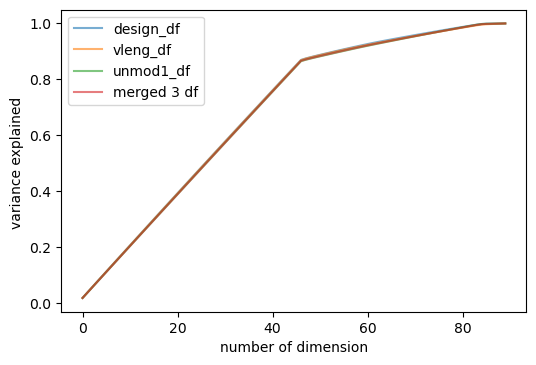

In [71]:
PCA_fig = plt.figure(dpi=100)
ax = PCA_fig.gca()
plot_explained_variance_curve(design_recons_V,ax=ax,**{"label":"design_df","alpha":0.6})
plot_explained_variance_curve(vleng_recons_V,ax=ax,**{"label":"vleng_df","alpha":0.6})
plot_explained_variance_curve(unmod1_recons_V,ax=ax,**{"label":"unmod1_df","alpha":0.6})
# merge
plot_explained_variance_curve(merge_V,ax=ax,**{"label":"merged 3 df","alpha":0.6})

plt.legend();

 we pick 47 as the PCA dimension

In [26]:
merge_df = vleng_df.append([unmod1_df,design_df])

In [8]:
merge_PC = PCA(n_components=47).fit_transform(merge_latent)

print(merge_PC.shape)

(532580, 47)


In [28]:
# 1 % of the whole dataset
# index of sampled points
downsampling = np.random.randint(0,merge_PC.shape[0],(5325))

def labeling_by_index(index):
    if index < 106530:
        return 0
    elif index < 432563: #106530+326033
        return 1
    elif index < 532580:
        return 2

downsampled_PC = merge_PC[downsampling]
df_source_label = np.array([labeling_by_index(idx) for idx in downsampling])

downsampled_df = merge_df.iloc[downsampling]

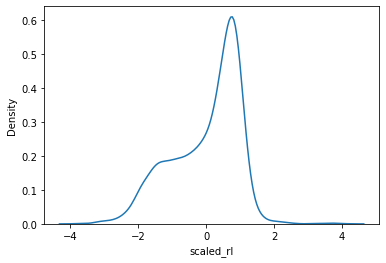

In [35]:
def expression_level(rl):
    if rl < -1.5:
        return 0
    elif rl < 1:
        return 1
    else:
        return 2

downsampled_rl_label = downsampled_df.scaled_rl.apply(expression_level).values
sns.kdeplot(downsampled_df.scaled_rl);

In [14]:
downsampled_PC.shape

(5325, 47)

In [17]:
downsampled_tnse = TSNE(metric='euclidean',verbose=True).fit_transform(downsampled_PC) 

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5325 samples in 0.053s...
[t-SNE] Computed neighbors for 5325 samples in 3.175s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5325
[t-SNE] Computed conditional probabilities for sample 2000 / 5325
[t-SNE] Computed conditional probabilities for sample 3000 / 5325
[t-SNE] Computed conditional probabilities for sample 4000 / 5325
[t-SNE] Computed conditional probabilities for sample 5000 / 5325
[t-SNE] Computed conditional probabilities for sample 5325 / 5325
[t-SNE] Mean sigma: 1.359767
[t-SNE] KL divergence after 250 iterations with early exaggeration: 88.269310
[t-SNE] KL divergence after 1000 iterations: 4.086279


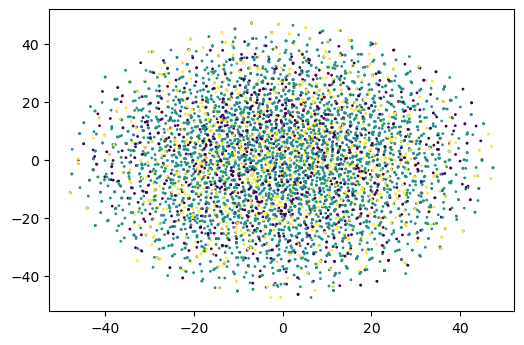

In [37]:
plt.figure(dpi=100)
plt.scatter(downsampled_tnse[:,0],downsampled_tnse[:,1],s=1,c=df_source_label);

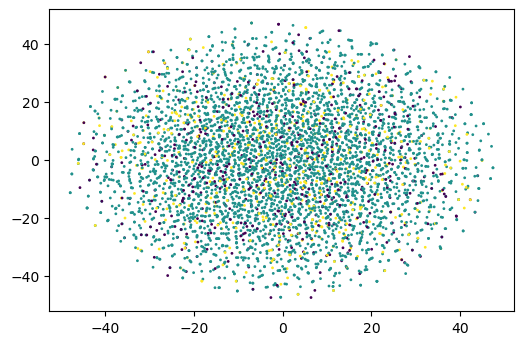

In [40]:
plt.figure(dpi=100)
plt.scatter(downsampled_tnse[:,0],downsampled_tnse[:,1],s=1,c=downsampled_rl_label);

In [23]:
downsampled_cosine_tnse = TSNE(metric='cosine',verbose=True).fit_transform(downsampled_PC) 

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5325 samples in 0.001s...
[t-SNE] Computed neighbors for 5325 samples in 1.043s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5325
[t-SNE] Computed conditional probabilities for sample 2000 / 5325
[t-SNE] Computed conditional probabilities for sample 3000 / 5325
[t-SNE] Computed conditional probabilities for sample 4000 / 5325
[t-SNE] Computed conditional probabilities for sample 5000 / 5325
[t-SNE] Computed conditional probabilities for sample 5325 / 5325
[t-SNE] Mean sigma: 0.196685
[t-SNE] KL divergence after 50 iterations with early exaggeration: 91.525101
[t-SNE] KL divergence after 1000 iterations: 4.009688


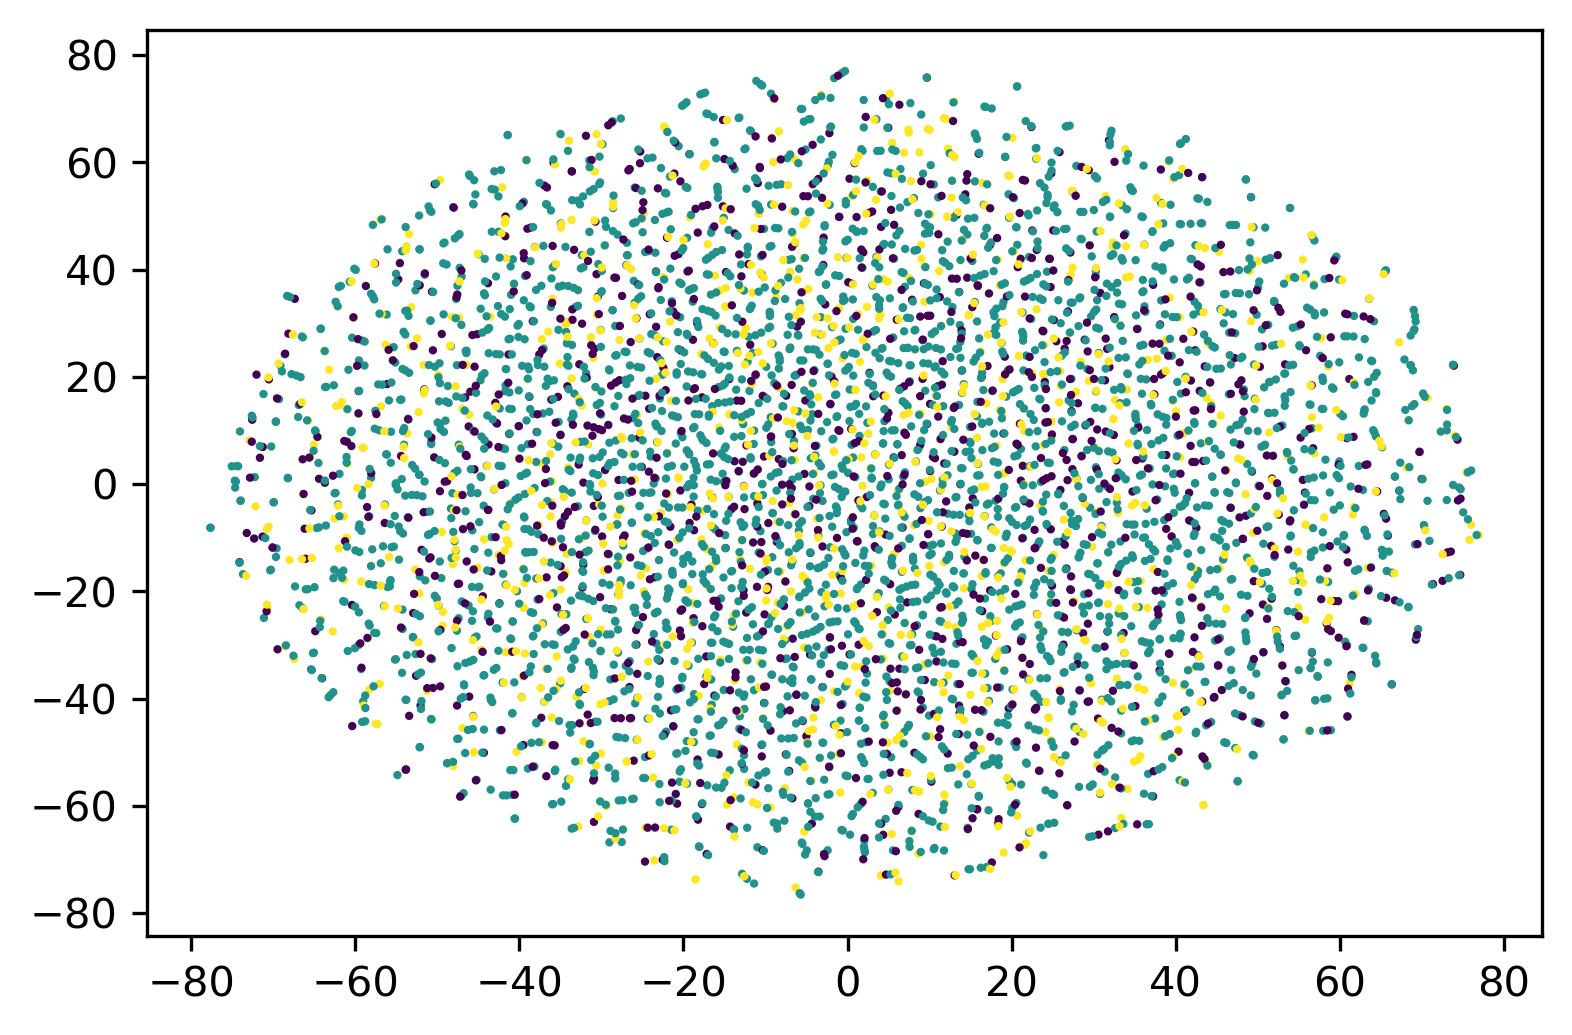

In [24]:
plt.figure(dpi=300)
plt.scatter(downsampled_cosine_tnse[:,0],downsampled_cosine_tnse[:,1],s=1,c=df_source_label);